In [53]:
import pydotplus 
import pandas as pd

from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_boston
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Задача 1.1

Сравним две описанные стратегии: $y_1^* = \overline{Y}_{leaf},\ y_2^* \sim U\{y_{1leaf},\ldots,y_{nleaf}\}$.

$E(y - y_1^*)^2 = y^2 - 2y\overline{Y}_{leaf} + \overline{Y}_{leaf}^2$

$E(y - y_2^*)^2 = y^2 - 2yEy_2^* + E(y_2^*)^2 = y^2 - 2y\overline{Y}_{leaf} + E(y_2^*)^2$

$\overline{Y}_{leaf}^2 = (Ey_2^*)^2 \leq E(y_2^*)^2$, следовательно, лучше отвечать средним значением таргета на объектах обучающей выборки.

## Задача 1.2

Я не понимаю, насколько формальный ответ требуется в этой задаче, но идея, на мой взгляд, следующая: если решающее дерево хорошее, в листья попадают близкие значения, и линейная регрессия на них почти константа. Кажется, для использования линейной регрессии лучше разбивать данные так, чтобы в листья попадали множества, элементы которых близки в пространстве признаков (например, отрезки, если пространство признаков одномерное). В предположении, что мы приближаем "хорошую" функцию, маленькие её участки близки к линейным и хорошо приблизятся линейной регрессией.

## Задача 2

In [40]:
data = pd.read_csv('german_credit.csv')

In [41]:
model = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=20)
model.fit(data.iloc[:, 1:].as_matrix(), data.iloc[:, 0].as_matrix())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [42]:
dot_data = tree.export_graphviz(model, out_file="tree.out", 
                         feature_names=list(data)[1:], 
                         class_names = ['0', '1'],
                         filled=True, rounded=True)

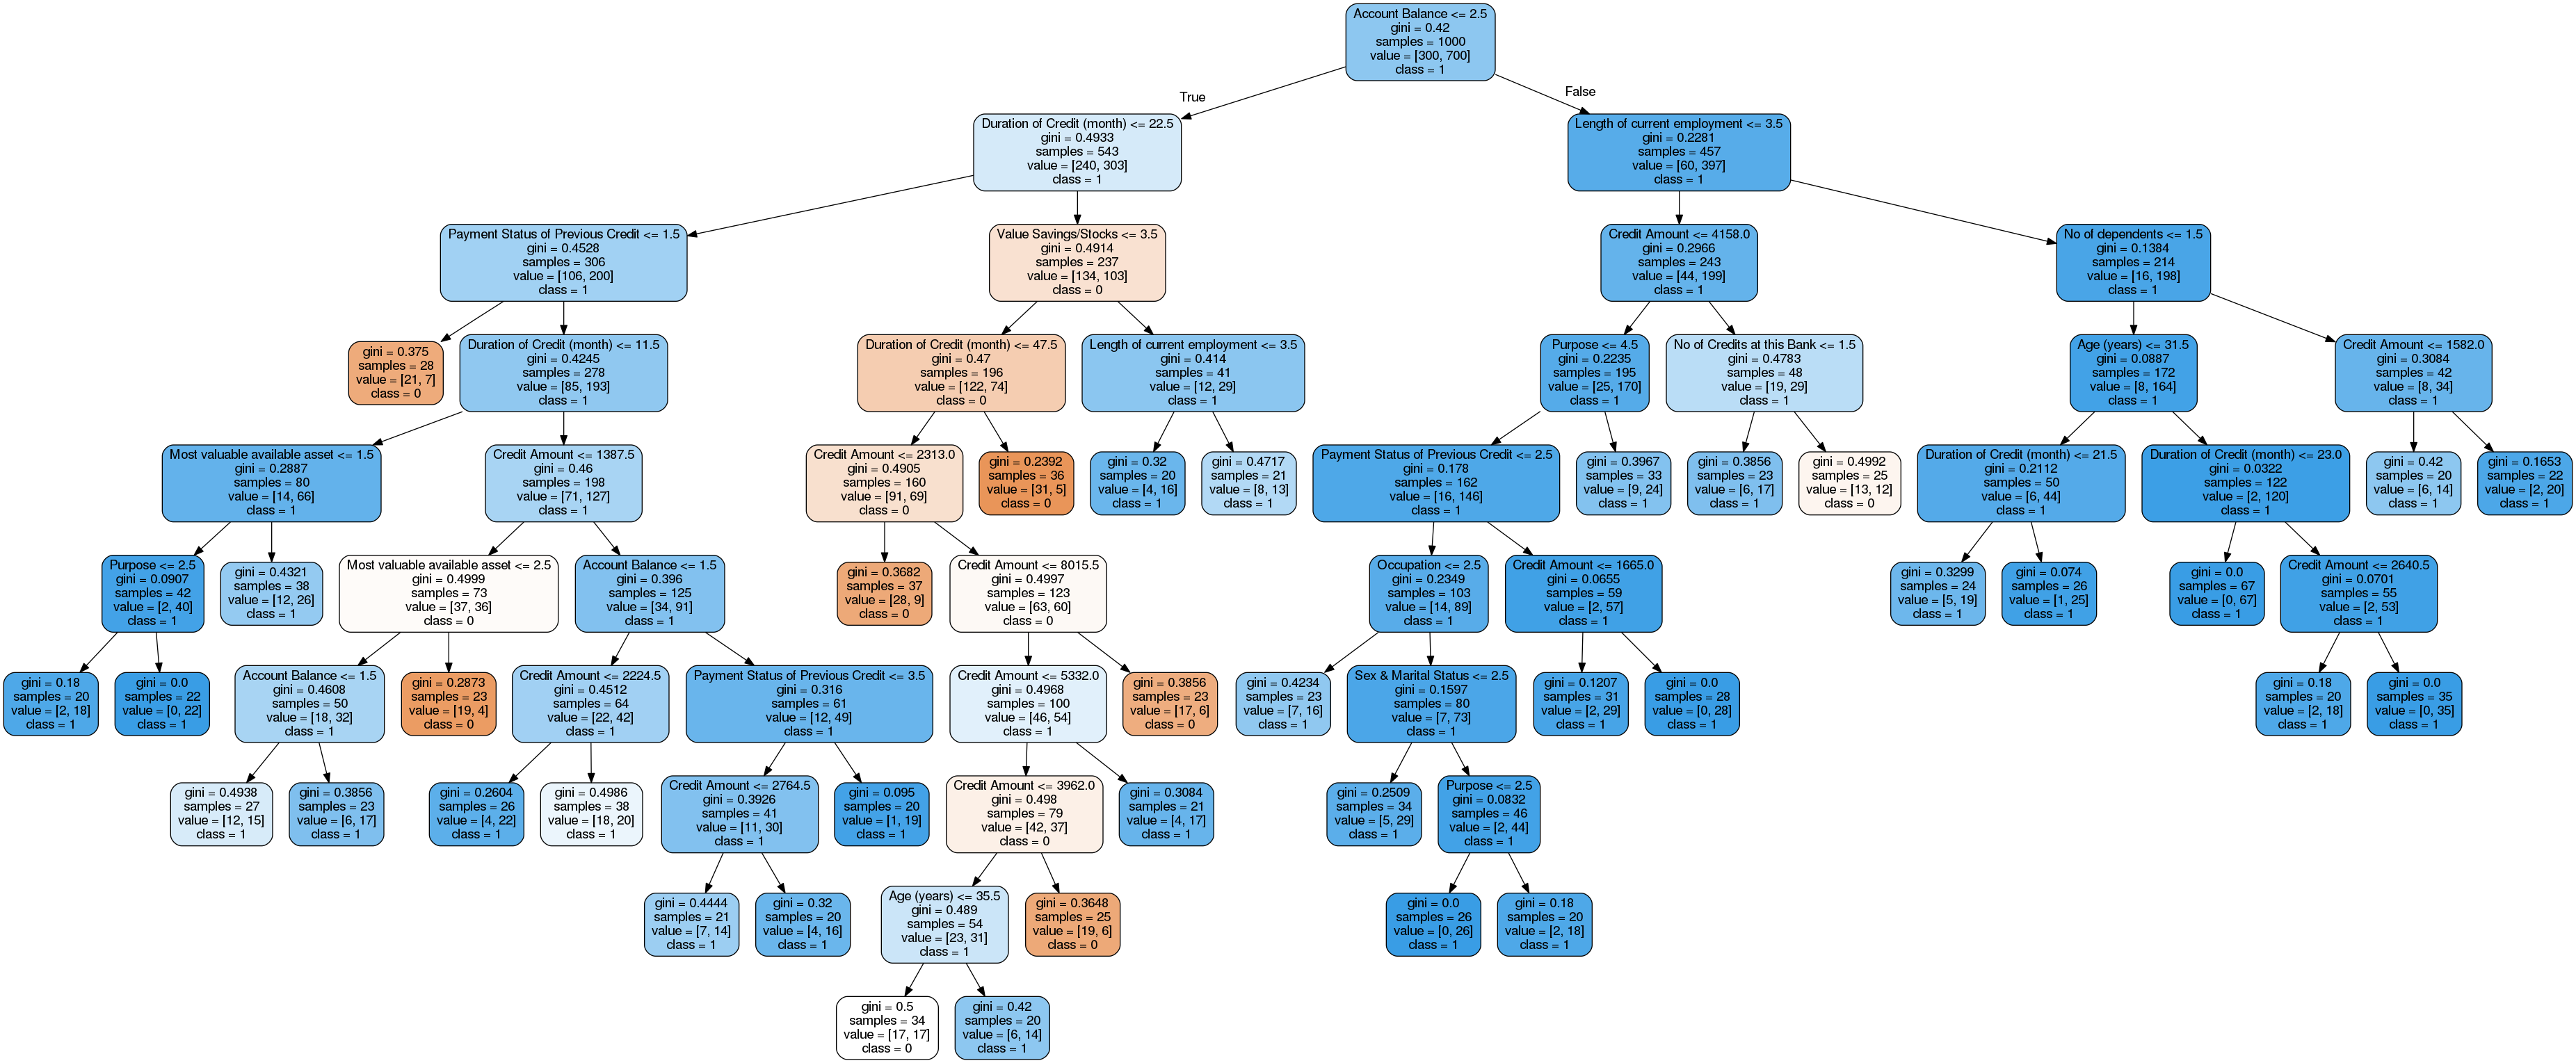

In [43]:
graph = pydotplus.graphviz.graph_from_dot_file("tree.out") 
Image(graph.create_png())

Построю дерево поменьше, чтобы проинтерпретировать несколько первых разбиений:

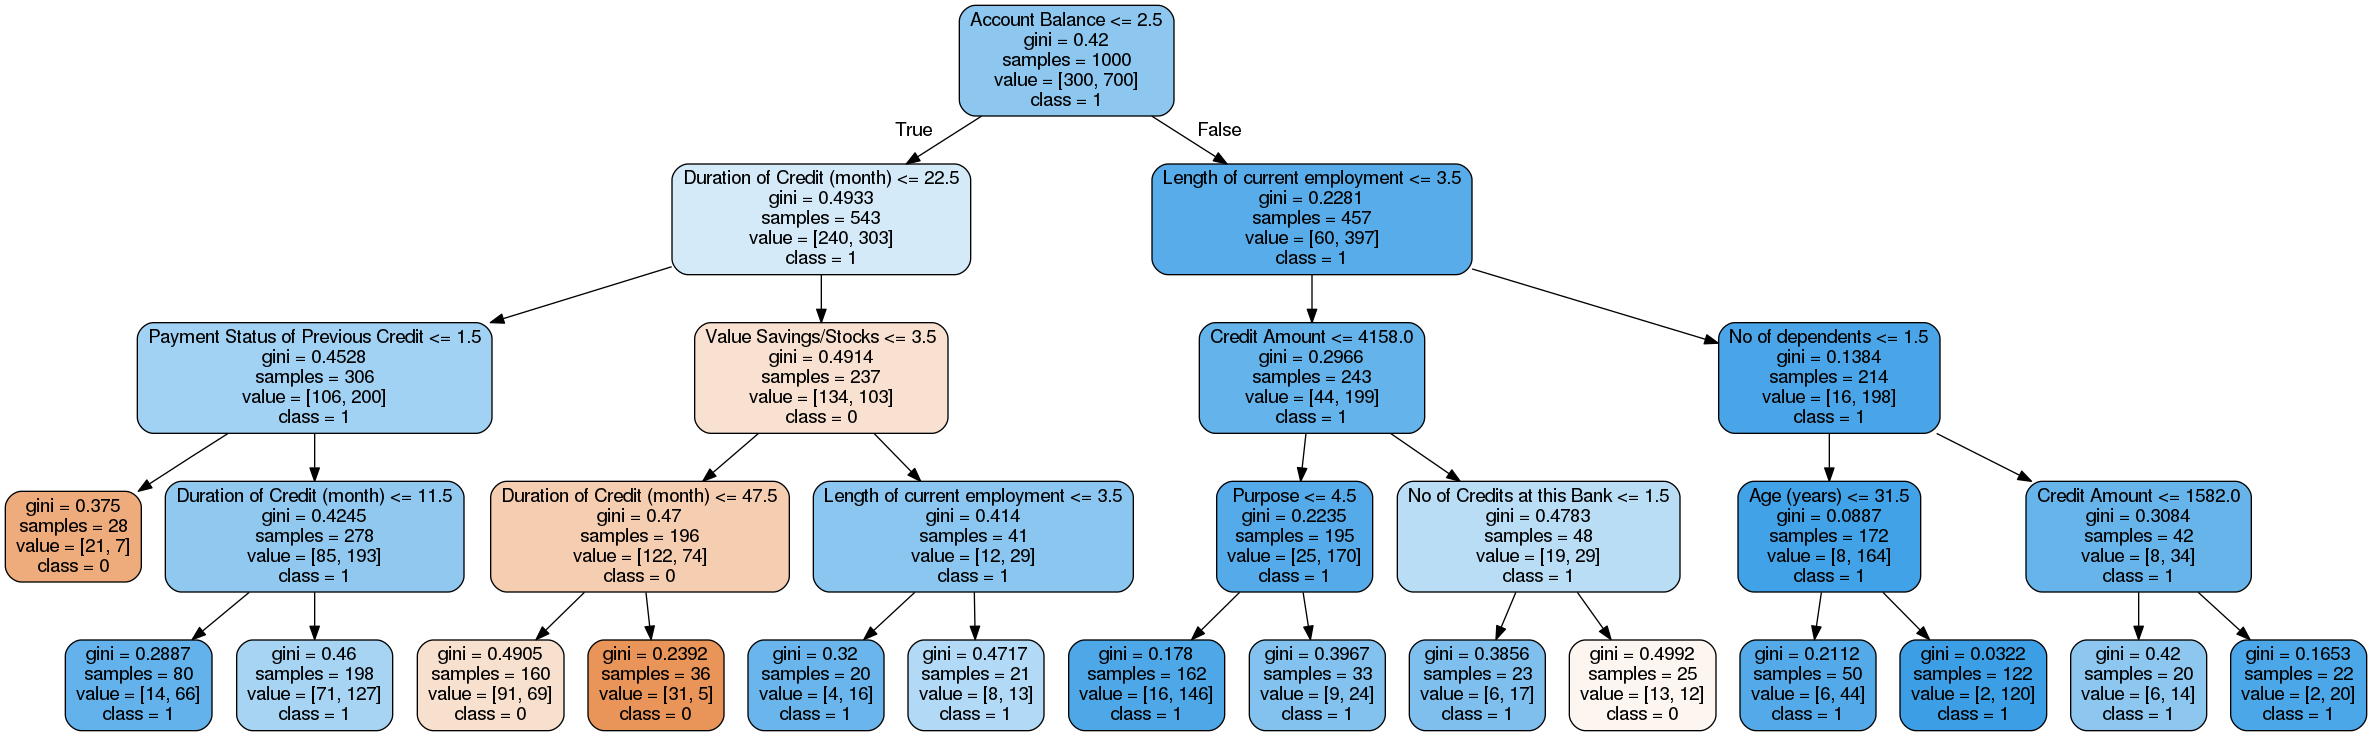

In [52]:
model = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=20)
model.fit(data.iloc[:, 1:].as_matrix(), data.iloc[:, 0].as_matrix())
dot_data = tree.export_graphviz(model, out_file="small_tree.out", 
                         feature_names=list(data)[1:], 
                         class_names = ['0', '1'],
                         filled=True, rounded=True)
graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
Image(graph.create_png())

Таким образом, первое, на что посмотрят сотрудники банка - деньги на вашем счету. Если их достаточно, то единственное, что может вам помешать - несколько уже взятых кредитов. Иначе шансы повышаются, если брать кредит на не слишком большой срок или хотя бы обладать сбережениями. Пытаться взять кредит на 2-4 года при небольшом количестве денег на счету и без впечатляющих сбережений - плохая идея.

In [51]:
def get_cross_val_qualities(data, max_depth):
    cross_val_quality = []
    for depth in range(1, max_depth):
        model = tree.DecisionTreeClassifier(max_depth=depth)
        cross_val_quality.append(cross_val_score(model, data.iloc[:, 1:].as_matrix(), 
                                                 data.iloc[:, 0], scoring='accuracy'))
    return np.average(cross_val_quality, axis=1)

def get_test_on_train_quality(data, max_depth):
    quality = []
    for depth in range(1, max_depth):
        model = tree.DecisionTreeClassifier(max_depth=depth)
        model.fit(data.iloc[:, 1:].as_matrix(), data.iloc[:, 0].as_matrix())
        pred = model.predict(data.iloc[:, 1:].as_matrix())
        quality.append(accuracy_score(data.iloc[:, 0], pred))
    return quality
    

In [46]:
max_depth = 35

In [47]:
tt_quality = np.array(get_test_on_train_quality(data, max_depth))

In [48]:
cross_val_quality = np.array(get_cross_val_qualities(data, max_depth))

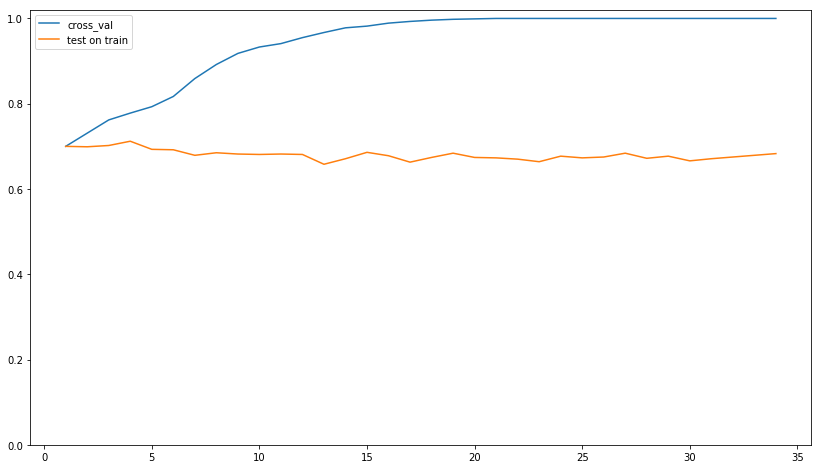

Cross validation score maximum is at depth = 3


In [49]:
x = np.array(range(1, max_depth))
plt.figure(figsize = (14, 8))
plt.plot(x, tt_quality, label="cross_val")
plt.plot(x, cross_val_quality, label="test on train")
plt.ylim([0., 1.02])
plt.legend()
plt.show()
print("Cross validation score maximum is at depth = {}".format(
    np.argmax(cross_val_quality)))

Ожидаемым образом дерево быстро переобучается, если тестить на тренировочной выборке. Иначе дерево хорошо работает уже при маленькой глубине.

In [55]:
data = load_boston()
print(data.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Судя по данным, нужно построить регрессионное решающее дерево :)

In [ ]:
def error(y):
    return 

In [57]:
class DecisionTree:
    def __init__(self, max_depth=100):
        self.max_depth = max_depth
        self.error = np.var
        
    def get_best_division(self, data):
        return attribute, treshold
    
    def fit(self, data, target):
        self.tree = {}
    
    def predict(self, data, target):
        pass